# Computational materials science

## Introduction
In this tutorial, you will use `AiiDA-WorkGraph` to carry out a DFT calculation using Quantum ESPRESSO.

## Requirements
To run this tutorial, you need to install `aiida-workgraph`, `aiida-quantumespresso` and `aiida-pseudo`. Open a terminal and run:

```console
pip install aiida-workgraph aiida-quantumespresso aiida-pseudo
aiida-pseudo install sssp -x PBEsol
```

Start the AiiDA daemon if needed:
```console
verdi daemon start
```

### Start the web server
Open a terminal, and run:
```
workgraph web start
```
Then visit the page http://127.0.0.1:8000/workgraph, you can view the workgraph later from here.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow: calculate the energy of N2 molecule
### Define a workgraph
aiida-quantumespresso provides a CalcJob: `PwCalculation` to run a PW calculation. we can use it directly in the WorkGraph. The inputs and outputs of the node is automatically generated based on the `PwCalculation` CalcJob.

In [2]:
from aiida_quantumespresso.calculations.pw import PwCalculation
from aiida_workgraph import WorkGraph

wg = WorkGraph("energy_n2")
pw1 = wg.tasks.new(PwCalculation, name="pw1")
pw1.to_html()

# visualize the node in jupyter-notebook
# pw1

### Prepare the inputs and submit the workflow


In [3]:
from aiida import load_profile
from aiida.orm import Dict, KpointsData, StructureData, load_code, load_group
from ase.build import molecule

load_profile()
# create input structure node
mol = molecule("N2")
mol.center(vacuum=1.5)
mol.pbc = True
structure_n2 = StructureData(ase=mol)
# load the PW code
code = load_code("qe-7.2-pw@localhost")
paras = Dict({
        "CONTROL": {
            "calculation": "scf",
        },
        "SYSTEM": {
            "ecutwfc": 30,
            "ecutrho": 240,
            "occupations": "smearing",
            "smearing": "gaussian",
            "degauss": 0.1,
        },
    })
kpoints = KpointsData()
kpoints.set_kpoints_mesh([1, 1, 1])
# Load the pseudopotential family.
pseudo_family = load_group('SSSP/1.3/PBEsol/efficiency')
pseudos = pseudo_family.get_pseudos(structure=structure_n2)
#
metadata = {
    'options': {'resources': {
                'num_machines': 1,
                'num_mpiprocs_per_machine': 1,
            },
        }
    }

#------------------------- Set the inputs -------------------------
pw1.set({"code": code,
         "structure": structure_n2,
        "parameters": paras,
        "kpoints": kpoints,
        "pseudos": pseudos,
        "metadata": metadata
        })
#------------------------- Submit the calculation -------------------------
wg.submit(wait=True, timeout=200)
#------------------------- Print the output -------------------------
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(pw1.outputs["output_parameters"].value.get_dict()["energy"]))


WorkGraph node created, PK: 56388
Energy of an un-relaxed N2 molecule: -547.169


Generate node graph from the AiiDA process:

/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


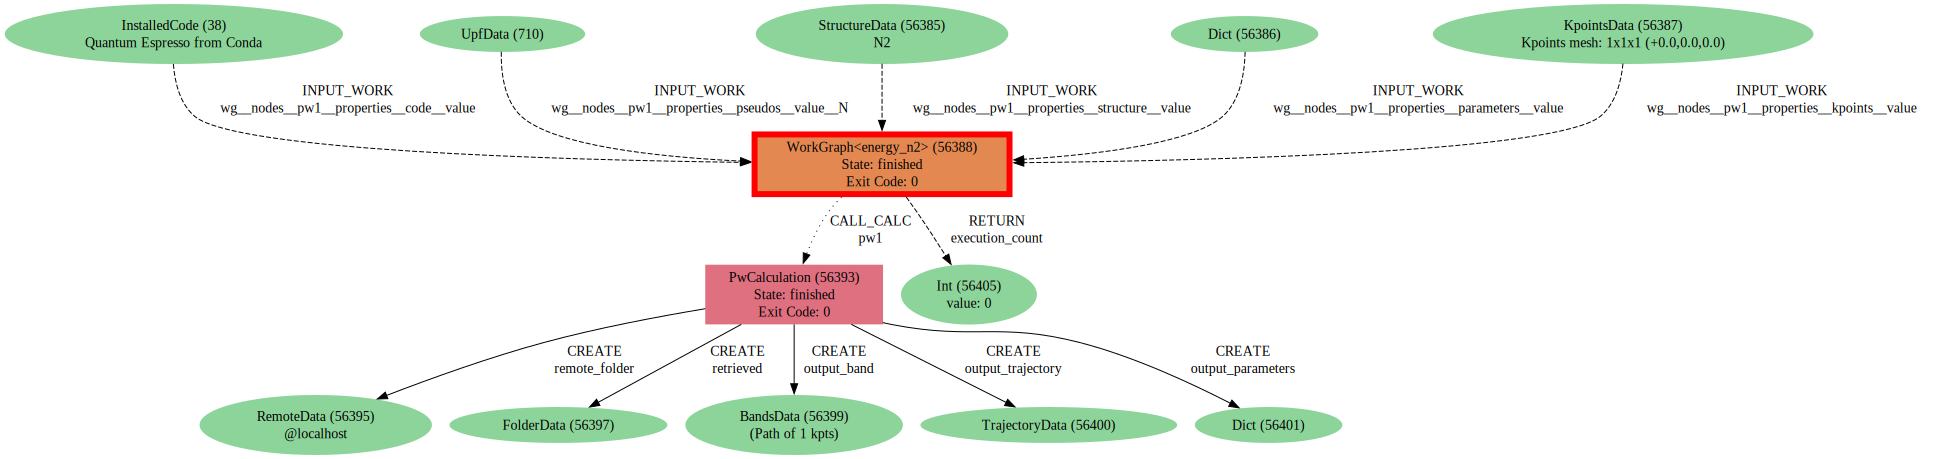

In [4]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Second workflow: atomization energy of N2 molecule

The atomization energy of $N_2$ is defined as the energy difference between the $N_2$ molecule and two isolated N atoms.
```python
e_atomization = 2 * e_atom - e_molecule
````

### Define a calcfunction to calculate the atomization energy

In [5]:
from aiida_workgraph import task

@task.calcfunction()
def atomization_energy(output_atom, output_mol):
    from aiida.orm import Float
    e = output_atom["energy"]*output_mol["number_of_atoms"] - output_mol["energy"]
    return Float(e)

Create the structure of nitrogen Atom.

In [6]:
from ase import Atoms
from aiida.orm import StructureData

atoms = Atoms("N")
atoms.center(vacuum=1.5)
atoms.pbc = True
structure_n = StructureData(ase=atoms)

### Create a workgraph

In [7]:
from aiida_workgraph import WorkGraph
from aiida.orm import  load_code

# load the PW code
code = load_code("qe-7.2-pw@localhost")

wg = WorkGraph("atomization_energy")

# create the PW node
pw_n = wg.tasks.new(PwCalculation, name="pw_n")
pw_n.set({"code": code, "structure": structure_n,
          "parameters": paras, "kpoints": kpoints,
          "pseudos": pseudos, "metadata": metadata
        })
pw_n2 = wg.tasks.new(PwCalculation, name="pw_n2")
pw_n2.set({"code": code, "structure": structure_n2,
           "parameters": paras, "kpoints": kpoints,
          "pseudos": pseudos, "metadata": metadata
        })
# create the node to calculate the atomization energy
atomization = wg.tasks.new(atomization_energy, name="atomization_energy")
wg.links.new(pw_n.outputs["output_parameters"], atomization.inputs["output_atom"])
wg.links.new(pw_n2.outputs["output_parameters"], atomization.inputs["output_mol"])
wg.to_html()

Submit the workgraph and print the atomization energy.

In [8]:
wg.submit(wait=True, timeout=300)
print('Atomization energy: {:0.3f} eV'.format(atomization.outputs["result"].value.value))

WorkGraph node created, PK: 56410
Atomization energy: 14.451 eV


If you start the web app (`workgraph web start`), you can visit the page http://127.0.0.1:8000/workgraph to view the nodes.

You can also generate node graph from the AiiDA process:

/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


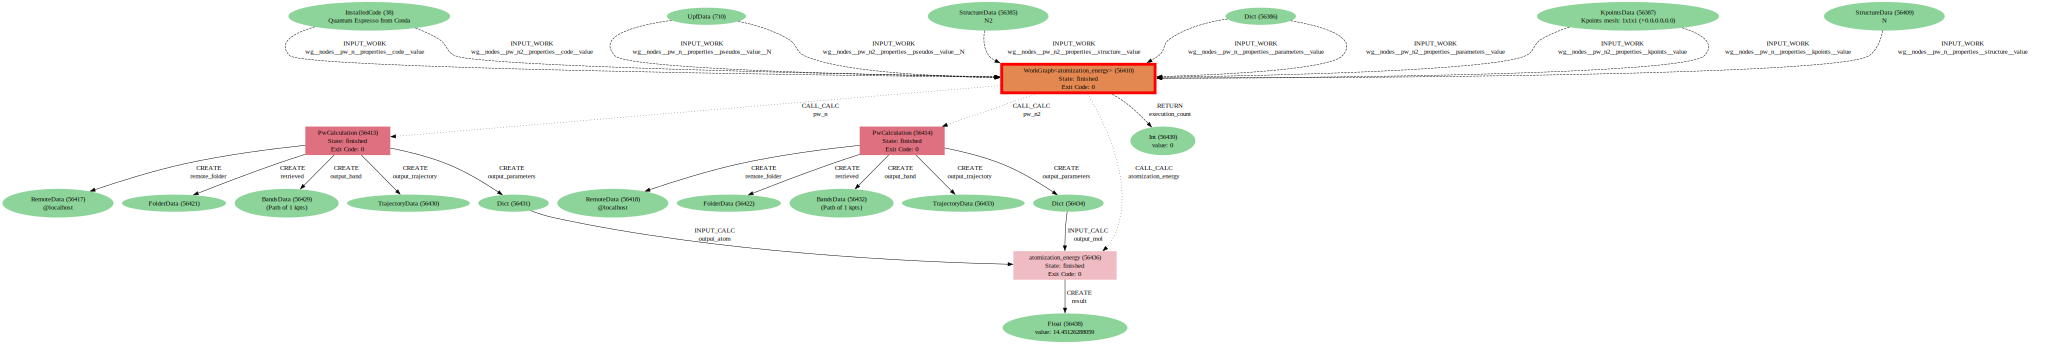

In [9]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Use already existing workchain
Can we register a node from a workchain? Can we set the a input item of a namespace? Yes, we can! 

In the `PwRelaxWorkChain`, one can set the relax type (`calculation` key) in the input namespace `base.pw.parameters`. Now we create a new node to update the pw parameters.

In [10]:
from aiida_workgraph.decorator import node


@task.calcfunction()
def pw_parameters(paras, relax_type):
    paras1 = paras.clone()
    paras1["CONTROL"]["calculation"] = relax_type
    return paras1

Now, we create the workgraph to relax the structure of N2 molecule.

In [13]:
from aiida_quantumespresso.workflows.pw.relax import PwRelaxWorkChain

wg = WorkGraph("test_pw_relax")
# pw node
pw_relax1 = wg.tasks.new(PwRelaxWorkChain, name="pw_relax1")
# Load the pseudopotential family.
pseudos = pseudo_family.get_pseudos(structure=structure_n2)
pw_relax1.set({
        "base": {
                "pw": {
                        "code": code,
                        "pseudos": pseudos,
                        "metadata": metadata
                },
                "kpoints": kpoints,
                },
        
        "structure": structure_n2,
        },
        )
paras_node = wg.tasks.new(pw_parameters, "parameters",
                          paras = paras,
                          relax_type = "relax")
wg.links.new(paras_node.outputs[0], pw_relax1.inputs["base.pw.parameters"])
wg.submit(wait=True, timeout=200)
print('\nEnergy of a relaxed N2 molecule: {:0.3f}'.format(pw_relax1.node.outputs.output_parameters.get_dict()["energy"]))

WorkGraph node created, PK: 56441

Energy of a relaxed N2 molecule: -547.232


Generate node graph from the AiiDA process:

In [ ]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Use `protocol` to set input parameters
The aiida-quantumespresso package supports setting input parameters from protocol. For example, the PwRelaxWorkChain has a `get_builder_from_protocol` method. In this tutorial, we will show how to use the `protocol` to set the input parameters inside the WorkGraph.

In [14]:
from aiida_workgraph import build_node, WorkGraph
from aiida_quantumespresso.workflows.pw.relax import PwRelaxWorkChain
from ase.build import bulk
from aiida import orm
from pprint import pprint

code = orm.load_code("qe-7.2-pw@localhost")
wg = WorkGraph("test_pw_relax")
structure_si = orm.StructureData(ase=bulk("Si"))
pw_relax1 = wg.tasks.new(PwRelaxWorkChain, name="pw_relax1")
# set the inputs from the protocol
# this will call the `PwRelaxWorkChain.get_builder_from_protocol` method
# to set the inputs of the workchain
pw_relax1.set_from_protocol(
    code,
    structure_si,
    protocol="fast",
    pseudo_family="SSSP/1.2/PBEsol/efficiency"
)
# we can now inspect the inputs of the workchain
print("The inputs for the PwBaseWorkchain are:")
print("-"*80)
pprint(pw_relax1.inputs["base"].value)
print("\nThe input parameters for pw are:")
print("-"*80)
pprint(pw_relax1.inputs["base"].value['pw']['parameters'].get_dict())

The inputs for the PwBaseWorkchain are:
--------------------------------------------------------------------------------
{'kpoints_distance': <Float: uuid: 894b24ea-88f0-4335-bc7e-3614573cb100 (unstored) value: 0.5>,
 'kpoints_force_parity': <Bool: uuid: 380d2819-9802-4cec-9edf-9bb9eeeba225 (unstored) value: False>,
 'max_iterations': <Int: uuid: f70b6d77-5515-45a0-9cb5-1f488b362eea (unstored) value: 5>,
 'metadata': {},
 'pw': {'code': <InstalledCode: Remote code 'qe-7.2-pw' on localhost pk: 38, uuid: 4f54a65b-0728-404a-b547-f8027d94c1ba>,
        'metadata': {'options': {'max_wallclock_seconds': 43200,
                                 'resources': {'num_machines': 1,
                                               'num_mpiprocs_per_machine': 1},
                                 'stash': {},
                                 'withmpi': True}},
        'monitors': {},
        'parameters': <Dict: uuid: 1b961fff-89de-4333-8418-5a2af7e14d35 (unstored)>,
        'pseudos': {'Si': <UpfData: 

One can also adjust the parameters of the `PwRelaxWorkChain` to from protocol.

In [15]:
# For example, we want to remove the `base_final_scf` from the inputs, so that the `PwRelaxWorkChain` will not run the `base_final_scf` step.
pw_relax1.inputs["base_final_scf"].value = None
# submit the workgraph
wg.submit(wait=True, timeout=200)


WorkGraph node created, PK: 56473


<WorkChainNode: uuid: 4cd5919f-559c-411a-bbc7-090bc6a8724e (pk: 56473) (aiida_workgraph.engine.workgraph.WorkGraphEngine)>

/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


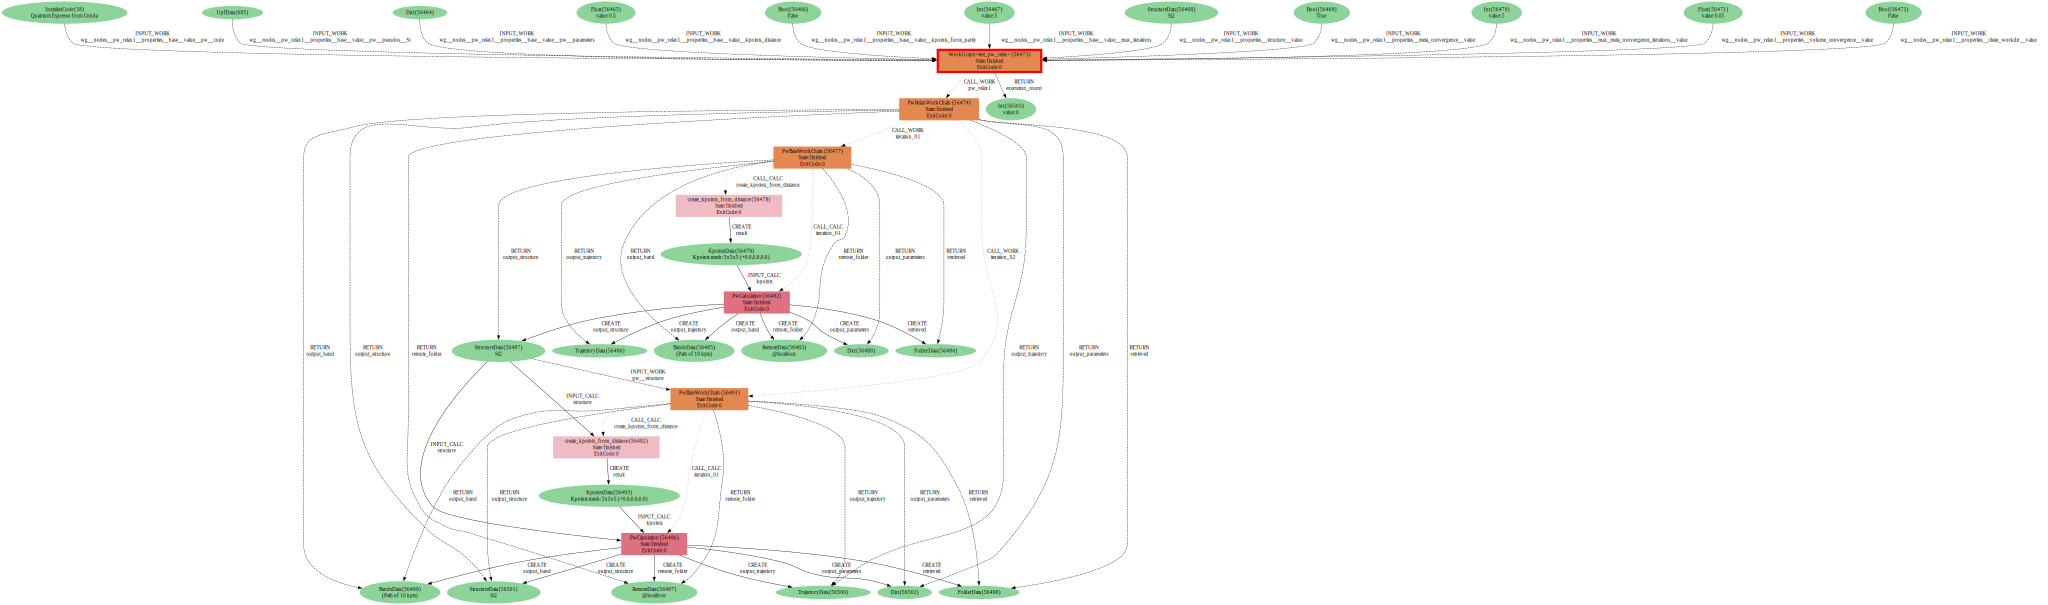

In [16]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)